In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns
import pickle

# aes
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':12})
# rc('text', usetex=True)

sns.set_context("notebook", font_scale=1.25)
 
file_path = "turl_test_2k_prompts_50.jsonl"
device = torch.device("mps")

model_name = "osunlp/TableLlama"
config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)

In [2]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [3]:
# load questions (to be removed)

file_path = "turl_test_2k_prompts_50.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [4]:
!ls ./644sample/

644.data.pickle


In [7]:
%%time

# load processed data

import os
import pickle

# prefix = './tablellama10runs/' # 10 runs on the first 100 prompts
prefix = './644sample/' # 4 runs on 344 prompts with at least 1 error and 344 prompts with no error

run = 0

outlist = []
for file in os.listdir(prefix):
    if file.endswith('pickle'):
        print(file)
        with open(os.path.join(prefix, file), 'rb') as handle:
            outlist_ = pickle.load(handle)
            for pid, item in enumerate(outlist_):
                if 'run' not in item: item['run'] = run
                else: run = max(run, item['run'])
                if 'pid' not in item: item['pid'] = pid
                outlist.append(item)
            # default (if ids do not exists)
            #outlist.extend([dict(item, **{'run': run, 'pid': pid}) for pid, item in enumerate(outlist_)])
    run += 1

len(outlist)

644.data.pickle
TableLlama.1608722137.pickle
CPU times: user 54.7 s, sys: 47.5 s, total: 1min 42s
Wall time: 2min 3s


3440

In [8]:
outlist_[-1]['run']

4

### check output against ground truth

In [9]:
%%time

# show results

c=0
t=0
h=0

truth = []
outseq = []

for idx, p in enumerate(outlist):
    print(idx, end='\r')
    c+=1
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    a = generated_text.lower().strip()
    b = p['output'].lower().strip()
    # correct
    correct = False
    hallucinated = False
    if (a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
        hallucinated = True
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')
        
    truth.append((p['run'], p['pid'], correct, hallucinated))
    outseq.append((p['run'], p['pid'], generated_text, b))

Token indices sequence length is longer than the specified maximum sequence length for this model (6471 > 4096). Running this sequence through the model will result in indexing errors


CPU times: user 25.5 s, sys: 764 ms, total: 26.2 s
Wall time: 28.3 s


In [10]:
# true, hallucinated, counted
t, h, c

(2374, 107, 3440)

In [11]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct', 'hallucinated'])

In [12]:
truth.describe(include='all')

,run,pid,correct,hallucinated
count,3440.000000,3440.000000,3440,3440
unique,NaN,NaN,2,2
top,NaN,NaN,True,False
freq,NaN,NaN,2374,3333
mean,2.000000,901.360465,NaN,NaN
std,1.414419,519.068896,NaN,NaN
min,0.000000,9.000000,NaN,NaN
25%,1.000000,449.250000,NaN,NaN
50%,2.000000,883.000000,NaN,NaN
75%,3.000000,1366.750000,NaN,NaN


<Axes: xlabel='correct', ylabel='Count'>

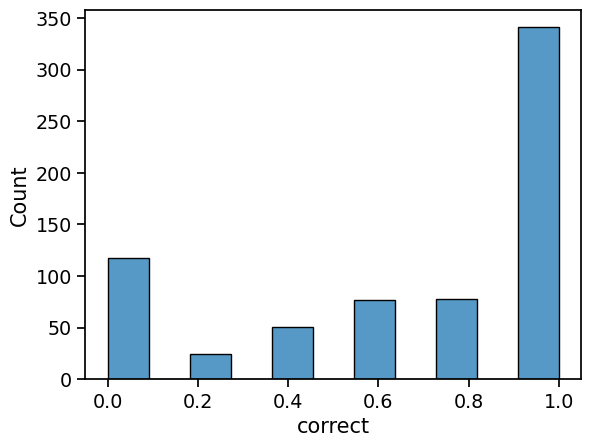

In [13]:
sns.histplot(truth.groupby('pid').correct.mean())

<Axes: xlabel='hallucinated', ylabel='Count'>

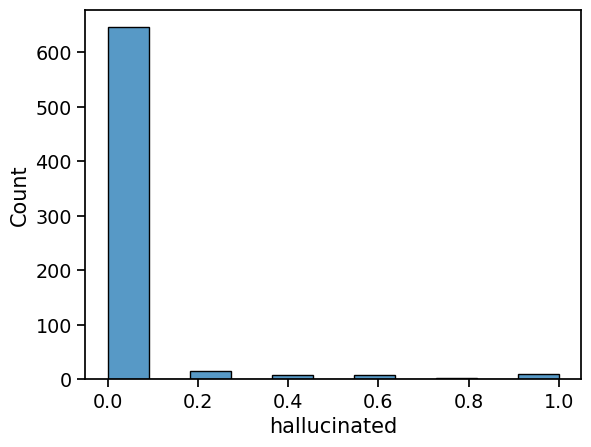

In [14]:
sns.histplot(truth.groupby('pid').hallucinated.mean())

In [15]:
truth.groupby('pid').size().value_counts()

5    688
Name: count, dtype: int64

In [112]:
truth

,run,pid,correct,hallucinated
0,0,9,False,False
1,0,10,False,False
2,0,12,False,False
3,0,14,False,False
4,0,17,True,False
...,...,...,...,...
3435,4,1788,True,False
3436,4,1789,True,False
3437,4,1790,False,False
3438,4,1794,True,False


In [16]:
accu = truth.groupby('pid').correct.mean()

In [17]:
accu[accu<1.].shape

(347,)

In [18]:
accu.value_counts()

correct
1.0    341
0.0    117
0.8     78
0.6     77
0.4     51
0.2     24
Name: count, dtype: int64

In [19]:
# answers
answers = pd.DataFrame(outseq, columns=['run', 'pid', 'answer', 'right_answer'])
answers.answer = answers.answer.str[:-1]

### sequence components alignment
### (build "segments" for each sequence)

In [20]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [21]:
%%time

checks = []
alls = set()

for idx, p in enumerate(outlist):
    
    print(idx, end='\r')
    
    run = p['run']
    pid = p['pid']
    
    alls.add(p['table'])

    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    output_seq = p['post_output_sequences'][0]

    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    instruction_match = is_sublist(instruction_seq[2:], output_seq, 'instruction')
    input_match = is_sublist(input_seq[2:], output_seq, 'input')
    question_match = is_sublist(question_seq[2:], output_seq, 'question') # maybe include 1?
    postilla_match = is_sublist(postilla_seq[2:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((run, pid, 0, instruction_match[0], 'preamble')) # preamble
    checks.append((run, pid, instruction_match[0] + 1) + instruction_match[1:])
    checks.append((run, pid, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    checks.append((run, pid, input_match[1] + 1) + question_match[1:]) # sew to preceding
    checks.append((run, pid, postilla_match[0] + 1, len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((run, pid, len(prompt_seq), len(output_seq) -1, 'generated')) # assume everything else is generated

CPU times: user 58.8 s, sys: 691 ms, total: 59.5 s
Wall time: 59.6 s


In [22]:
# check the checks (must be False)
'False' in checks

False

In [23]:
segments = pd.DataFrame(checks, columns = ['run', 'pid', 'start', 'end', 'segment'])

In [24]:
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})

In [25]:
segments['length'] = segments.end - segments.start

In [26]:
segments

,run,pid,start,end,segment,seq,length
0,0,9,0,40,preamble,0,40
1,0,9,41,135,instruction,1,94
2,0,9,136,5117,input,2,4981
3,0,9,5118,6405,question,3,1287
4,0,9,6406,6470,postilla,4,64
...,...,...,...,...,...,...,...
20635,4,1797,41,135,instruction,1,94
20636,4,1797,136,859,input,2,723
20637,4,1797,860,5398,question,3,4538
20638,4,1797,5399,5463,postilla,4,64


### segment description

In [27]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

,segment,seq,avg_length,std_length,min_length,max_length,avg_length_rel,avg_cumlen
4,preamble,0,40.000000,0.000000,40,40,0.012028,0.012028
2,instruction,1,94.000000,0.000000,94,94,0.028265,0.040293
1,input,2,1825.149709,1572.661174,141,6987,0.548810,0.589103
5,question,3,1277.675872,399.419739,79,4543,0.384189,0.973292
3,postilla,4,64.000000,0.000000,64,64,0.019244,0.992536
0,generated,5,24.822384,5.895634,12,56,0.007464,1.000000


<Axes: xlabel='length', ylabel='Count'>

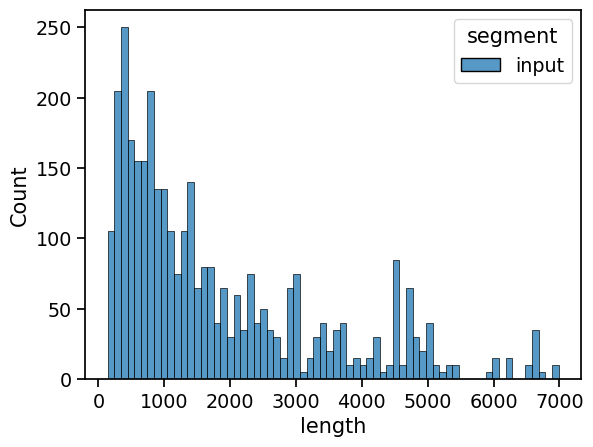

In [28]:
sns.histplot(segments[segments.segment=='input'], x='length', hue='segment', multiple='dodge', binwidth=100)

<Axes: xlabel='length'>

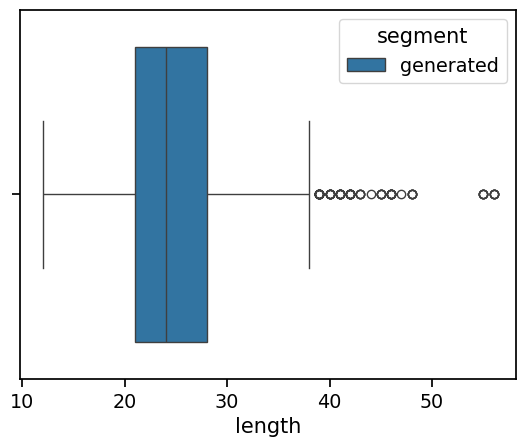

In [119]:
sns.boxplot(segments[segments.segment=='generated'], x='length', hue='segment')

<Axes: xlabel='segment', ylabel='length'>

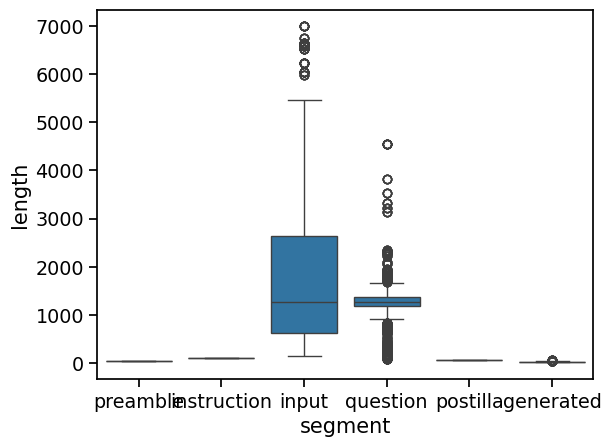

In [29]:
sns.boxplot(segments, y='length', x='segment')

In [30]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans (for the first viz above)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

### collect observables

In [31]:
%%time

shapes = []

# for each prompt
for i, p in enumerate(outlist):
    # for each token
    run = p['run']
    pid = p['pid']
    for j, pp in enumerate(p['pre_output_proba_topn']):
        shapes.append((run,pid,j,'prompt',
                           len(pp['top_n_indices']),
                           p['pre_output_true_entropies'][j],
                           max(pp['top_n_probs'])))
    for jj, pp in enumerate(p['post_output_proba_topn']):
        shapes.append((run,pid,j+jj+1,'generated',
                           len(pp['top_n_indices']),
                           p['post_output_true_entropies'][jj],
                           max(pp['top_n_probs'])))

CPU times: user 9.55 s, sys: 5.8 s, total: 15.3 s
Wall time: 16.7 s


In [32]:
%%time 

import pandas as pd
import numpy as np
d = pd.DataFrame(shapes, columns=['run', 'pid', 'tok', 'area', 'shape', 'true_ent', 'maxp'])

CPU times: user 6.57 s, sys: 2.36 s, total: 8.92 s
Wall time: 9.51 s


In [33]:
# are the max index equal in observables and segments (must be True)
d.groupby(['run','pid']).tok.max().sort_values().reset_index(drop=True).equals(segments.groupby(['run','pid']).end.max().sort_values().reset_index(drop=True))

True

In [34]:
# (first 10 in generated)
d[d.area=='prompt'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.tail(10)).describe()

,run,pid,tok,shape,true_ent,maxp
count,34400.000000,34400.000000,34400.000000,34400.000000,34400.000000,34400.000000
mean,2.000000,901.360465,3300.325581,6.872820,0.594069,0.842458
std,1.414234,519.000988,1603.596476,32.147666,0.930696,0.238385
min,0.000000,9.000000,488.000000,1.000000,0.000000,0.086365
25%,1.000000,449.250000,2078.750000,1.000000,0.000113,0.714233
50%,2.000000,883.000000,2775.500000,1.000000,0.016675,0.998047
75%,3.000000,1366.750000,4206.500000,2.000000,0.898675,1.000000
max,4.000000,1797.000000,8230.000000,946.000000,5.685452,1.000000


In [35]:
# (last 10 in prompt)
d[d.area=='generated'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.head(10)).describe()

,run,pid,tok,shape,true_ent,maxp
count,34400.000000,34400.000000,34400.000000,34400.000000,34400.000000,34400.000000
mean,2.000000,901.360465,3310.325581,1.053924,0.028655,0.986432
std,1.414234,519.000988,1603.596476,0.288795,0.142138,0.069687
min,0.000000,9.000000,498.000000,1.000000,0.000000,0.178259
25%,1.000000,449.250000,2088.750000,1.000000,0.000000,1.000000
50%,2.000000,883.000000,2785.500000,1.000000,0.000000,1.000000
75%,3.000000,1366.750000,4216.500000,1.000000,0.000000,1.000000
max,4.000000,1797.000000,8240.000000,10.000000,2.298839,1.000000


In [36]:
%%time

# attach sections

m = d.merge(segments, on=['run','pid'], how='left')
m = m[(m.start <= m.tok) & (m.tok <= m.end)]

CPU times: user 4.83 s, sys: 2.81 s, total: 7.64 s
Wall time: 8.47 s


In [37]:
m

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length
0,0,9,0,prompt,19127,9.342692,0.011505,0,40,preamble,0,40
6,0,9,1,prompt,4954,6.863560,0.110962,0,40,preamble,0,40
12,0,9,2,prompt,9,1.748911,0.684082,0,40,preamble,0,40
18,0,9,3,prompt,178,4.617726,0.093811,0,40,preamble,0,40
24,0,9,4,prompt,5,1.100033,0.811523,0,40,preamble,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...
68765189,4,1797,5483,generated,1,0.000000,1.000000,5464,5487,generated,5,23
68765195,4,1797,5484,generated,1,0.000000,1.000000,5464,5487,generated,5,23
68765201,4,1797,5485,generated,1,0.000000,1.000000,5464,5487,generated,5,23
68765207,4,1797,5486,generated,1,0.000000,1.000000,5464,5487,generated,5,23


In [38]:
# did we merge all the tokens to their segments (must be True)
d[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True).equals(m[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True))

True

In [39]:
# check that all the six sections are present in each prompt (must be True)
m.drop_duplicates(['pid', 'segment']).shape[0] == m.pid.nunique() * 6

True

In [40]:
# token position normalization

# normalized per section, offset by section sequence number
m['tok_rel_segm'] = m.tok / m.end

# normalized per section, each section same width
m['tok_rel_segm_abs'] = m.seq + ((m.tok - m.start) / (m.end - m.start))

# token relative to section start
m['tokzero'] = m['tok'] - m['start']

# token relative to section end (negative)
m['tokzero_end'] = m['tok'] - m['end'] - 1

### check variances

In [41]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [42]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [43]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [44]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [45]:
m[m.segment=='question'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.28828123

In [46]:
m[m.segment=='question'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.043671735

In [47]:
m[m.segment=='generated'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.00060769863

In [48]:
m[m.segment=='generated'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [49]:
if True:
    myoutdict = {'truth': truth, 'segments': segments, 'm': m, 'answers': answers}

    import pickle

    with open('preprocessed.pickle', 'wb') as handle:
        pickle.dump(myoutdict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [50]:
!ls -larth | grep preprocessed

-rw-r--r--   1 bono  staff    16M Feb 20 20:07 tablellama.preprocessed.pickle
-rw-r--r--@  1 bono  staff   1.3G Mar 12 11:49 preprocessed.pickle


In [52]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']
answers = mydict['answers']

In [53]:
mm = m.copy()

### single run plots

In [54]:
m = mm[mm.run==0].copy()

In [55]:
NUM_BINS = 100

100


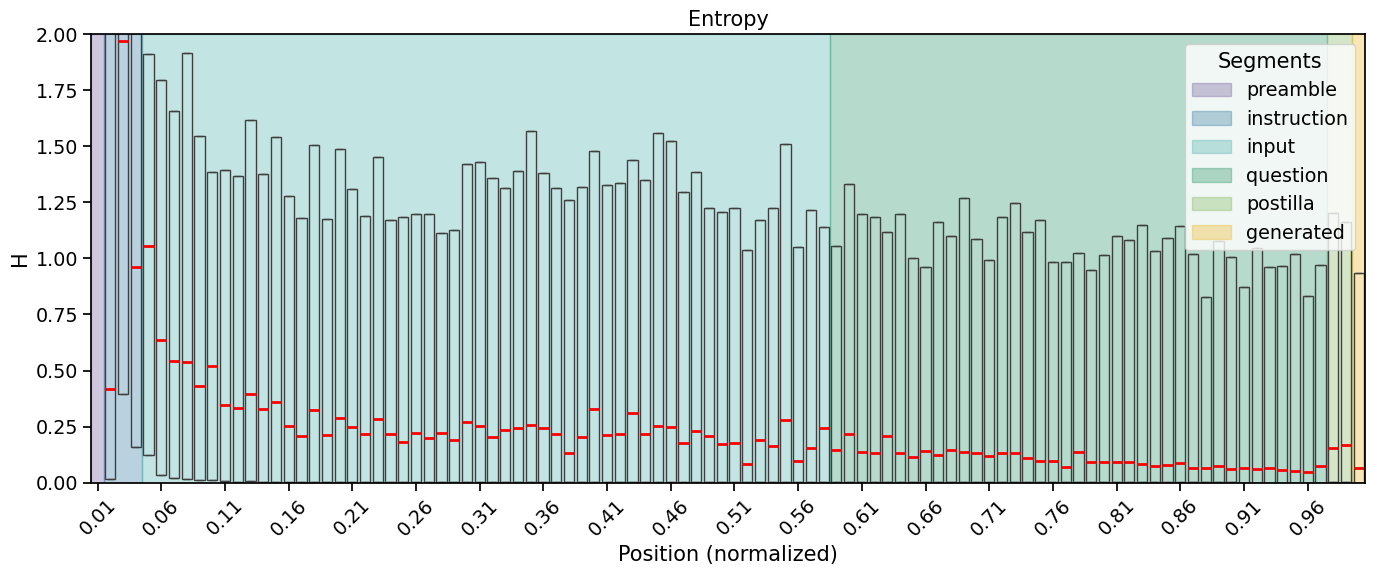

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.set(ylim=(0, 2))

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [57]:
ax.figure.savefig('./pdf/entropy_per_segment.pdf',dpi=600, bbox_inches="tight")

100


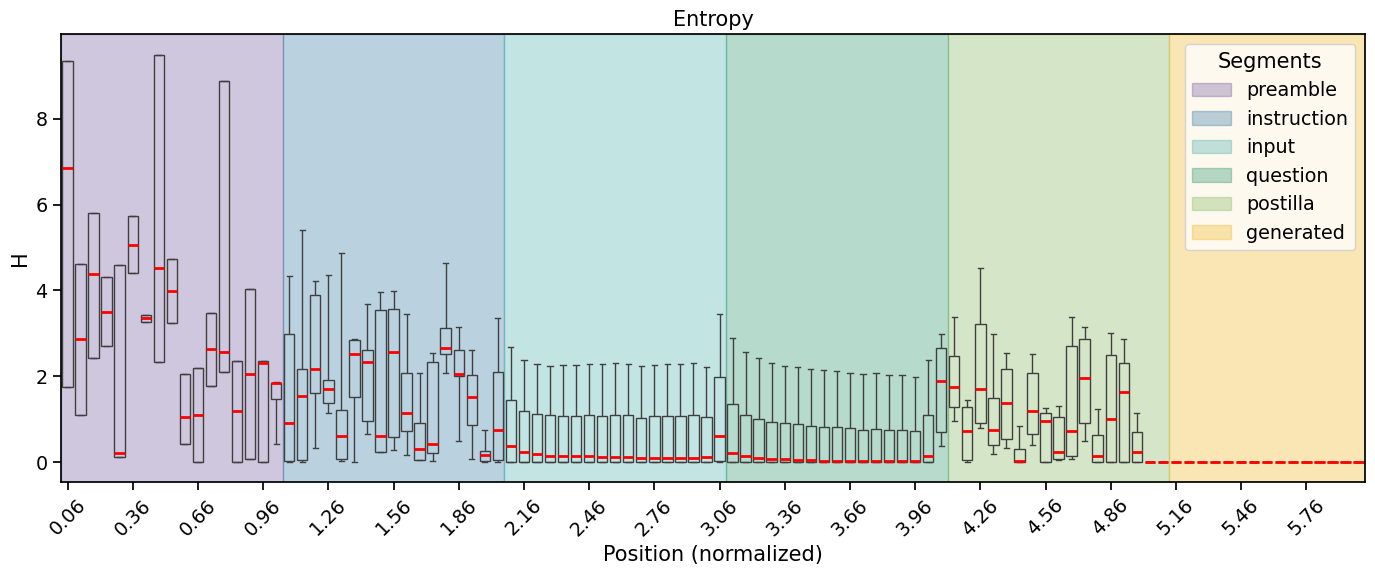

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm_abs'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))


patches = []
c = -0.5
delta = int(len(bks)/6)+1
for start, end, color, label in background_regions:
    ax.axvspan(c, c+delta, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 
    c += delta

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [59]:
ax.figure.savefig('./pdf/entropy_per_segment_unnorm.pdf',dpi=600, bbox_inches="tight")

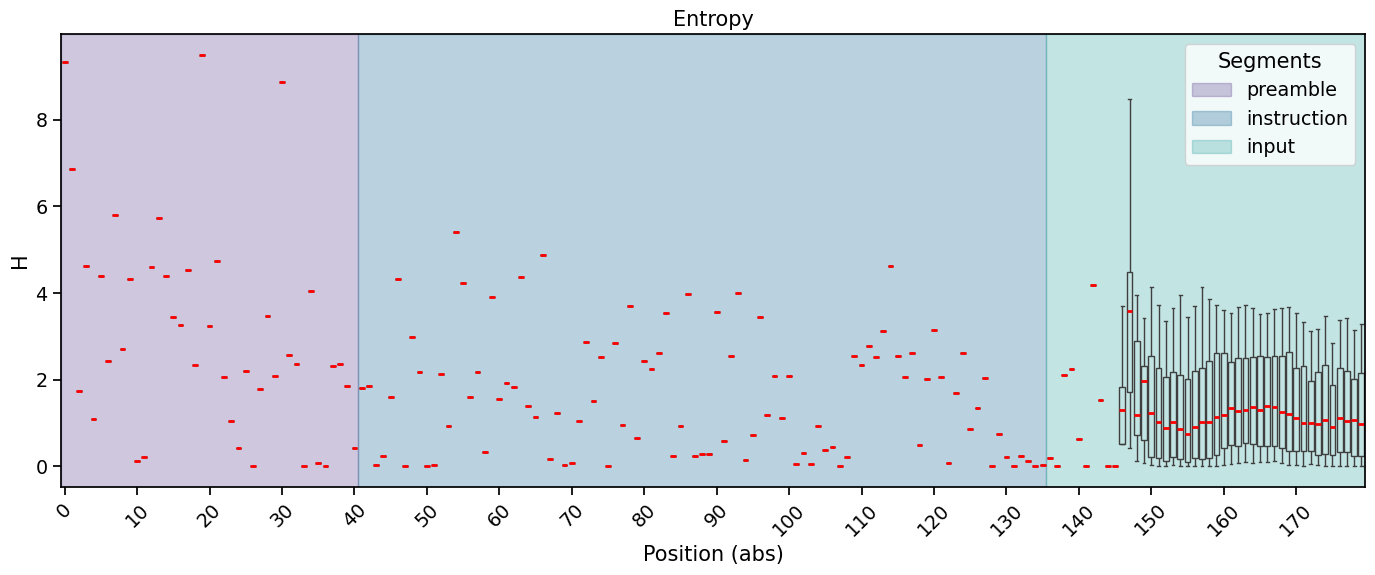

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = m[m.tok<180]

background_regions_ = [
    (0.0, 40.0, palette[0], 'preamble'),
    (41.0, 135.0, palette[1], 'instruction'),
    (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start -0.5, end + 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tok", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [114]:
segments.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [61]:
ax.figure.savefig('./pdf/entropy_beginning.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between input and question

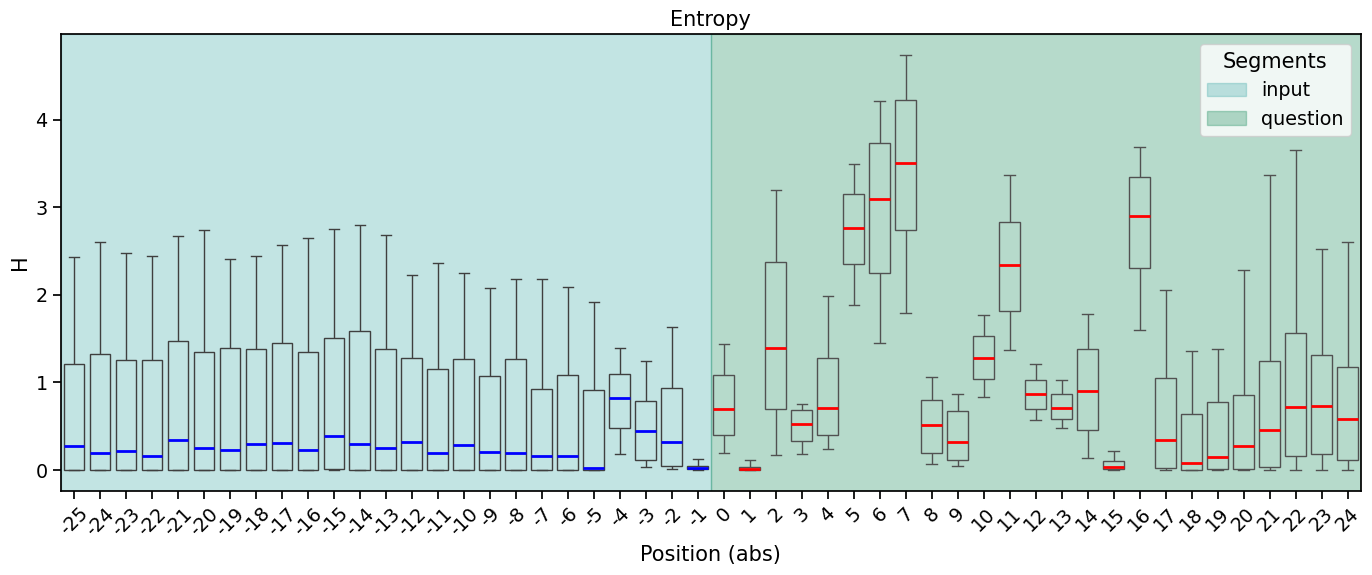

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'input') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[2], 'input'),
    (delta, 2*delta, palette[3], 'question'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'question') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [63]:
ax.figure.savefig('./pdf/entropy_boundary_input_and_question.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between  question and postilla

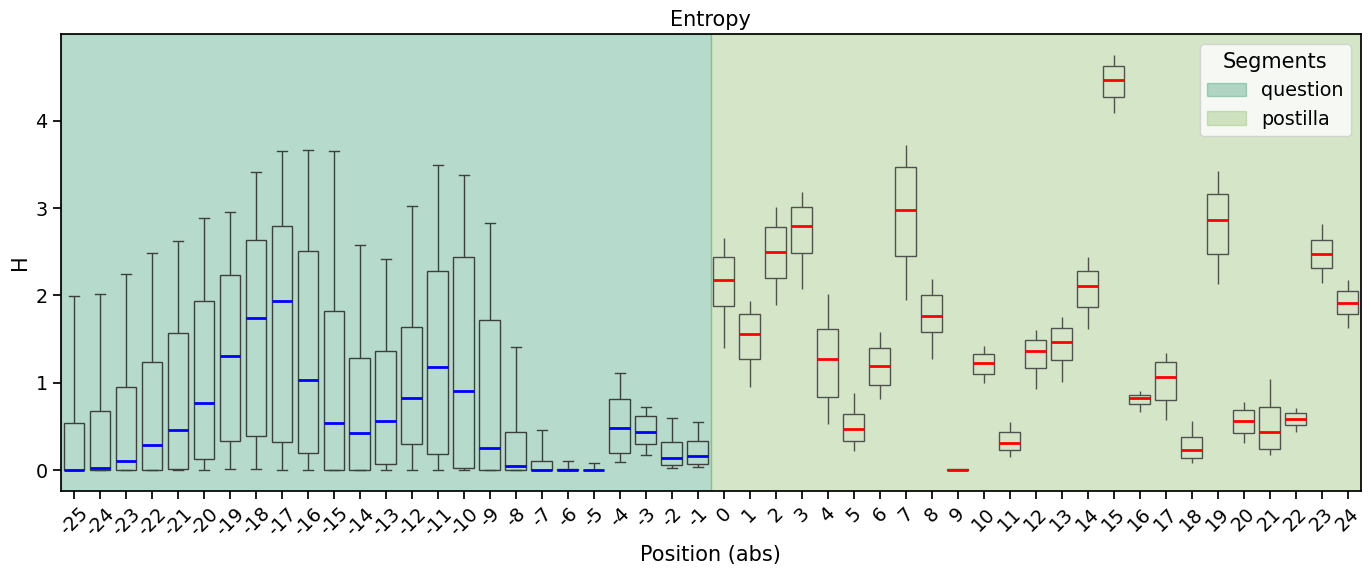

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'question') & (m.tokzero_end >= -delta))] #  

postillalen = m[m.segment=='postilla'].tokzero.max()

background_regions_ = [
    (0, delta, palette[3], 'question'),
    (delta, 2 * delta + 1, palette[4], 'postilla'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'postilla') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=False,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [65]:
ax.figure.savefig('./pdf/entropy_boundary_question_and_postilla.pdf',dpi=600, bbox_inches="tight")

### boundary between postilla and generated

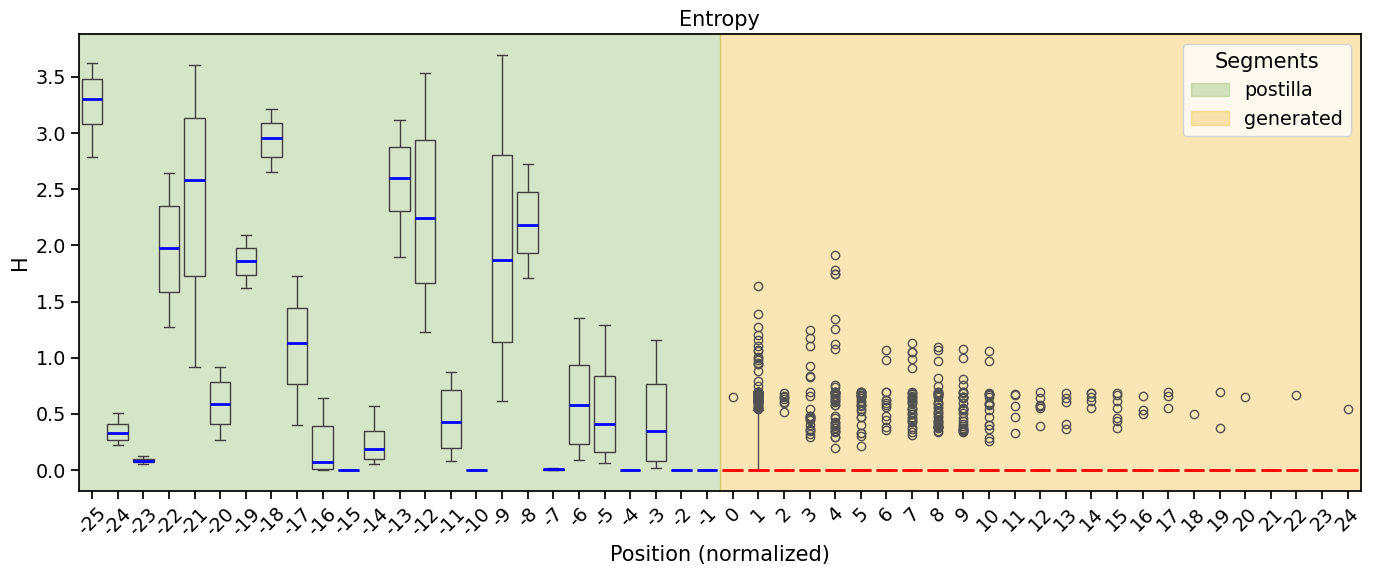

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [67]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated.pdf',dpi=600, bbox_inches="tight")

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_77422/2463233701.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_77422/2463233701.py:48: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(


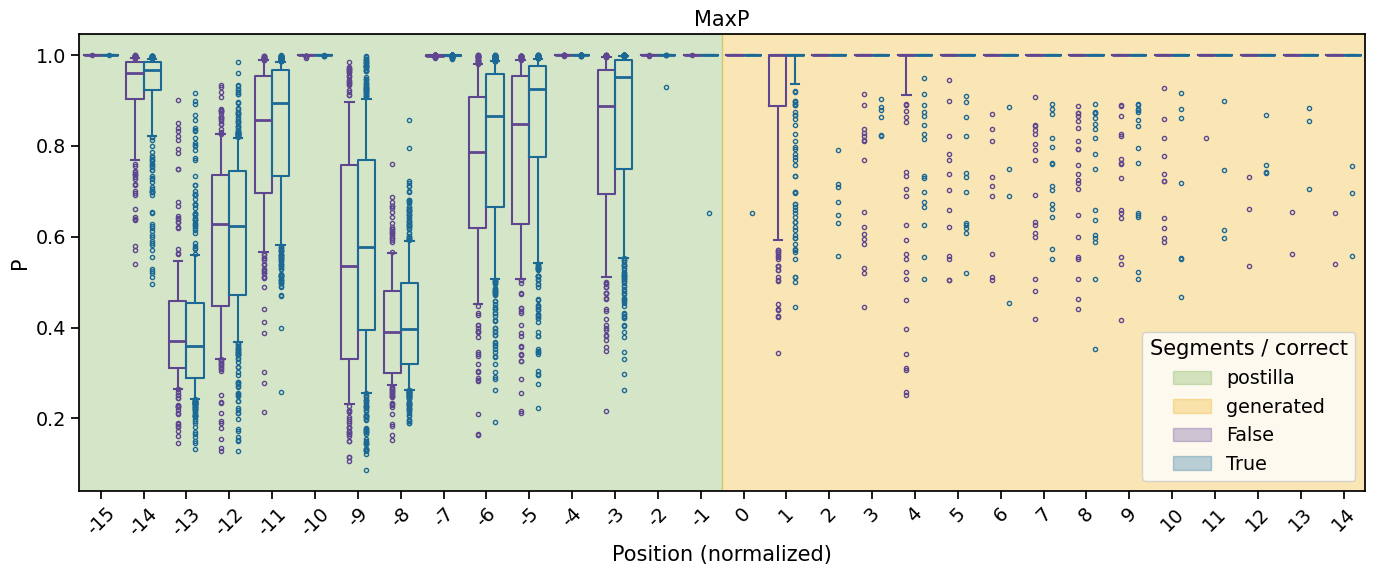

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=palette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=palette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

In [69]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated_grouped_by_correct.pdf',dpi=600, bbox_inches="tight")

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_77422/2499406647.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_77422/2499406647.py:48: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(


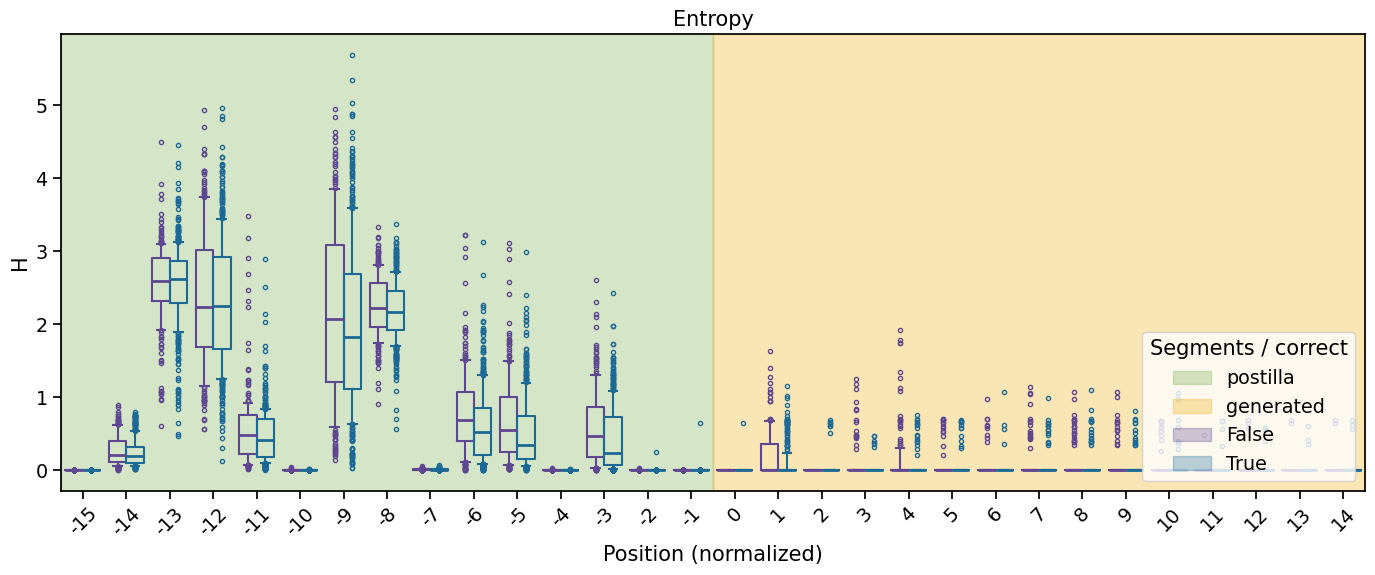

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=palette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=palette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

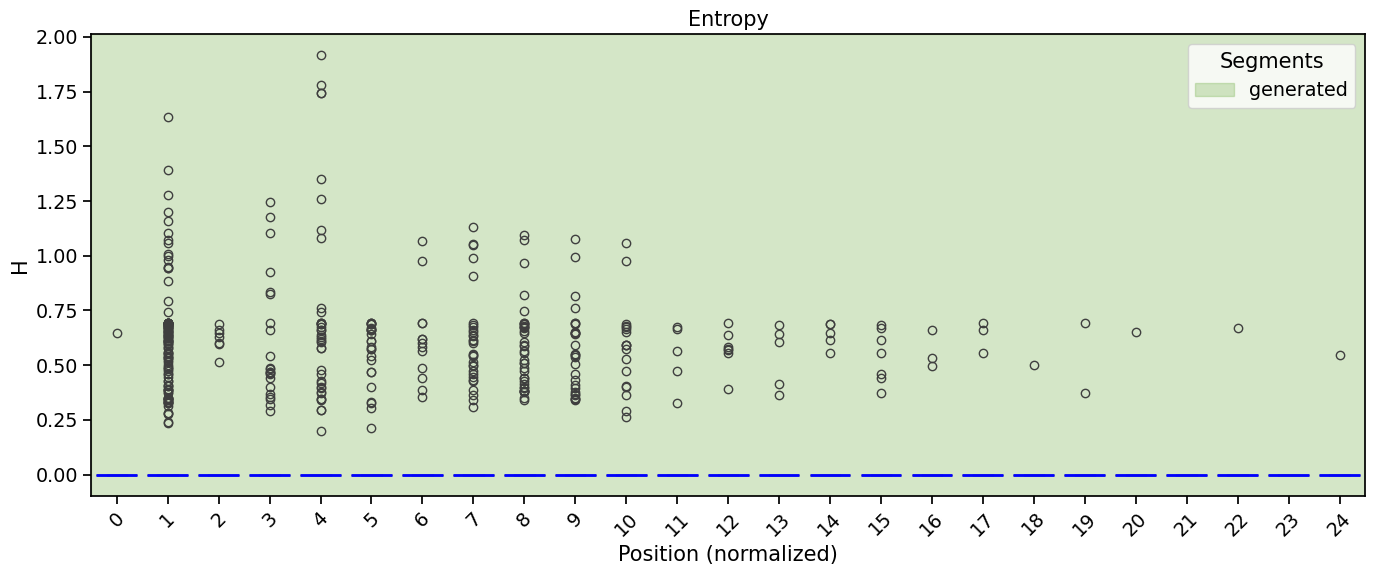

In [71]:
# only generated

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'generated') & (m.tokzero < delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [72]:
m.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [73]:
m[m.segment=='preamble'].groupby('pid').size().std()

0.0

In [74]:
m[m.segment=='instruction'].groupby('pid').size().std()

0.0

In [75]:
m[m.segment=='input'].groupby('pid').size().std()

1573.576576615972

In [76]:
m[m.tok_rel_segm_abs<1.].true_ent.var()

5.9572453

In [77]:
df[df.tok_bin_idx==0].true_ent.var()

10.00165

100


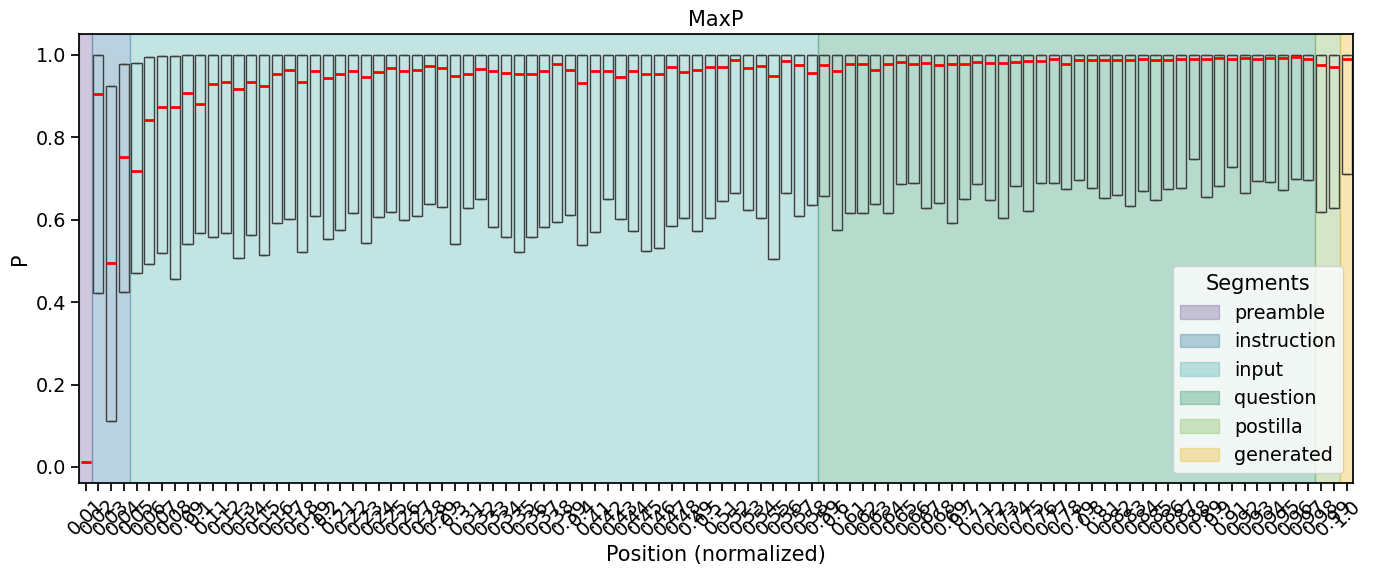

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="maxp", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

100


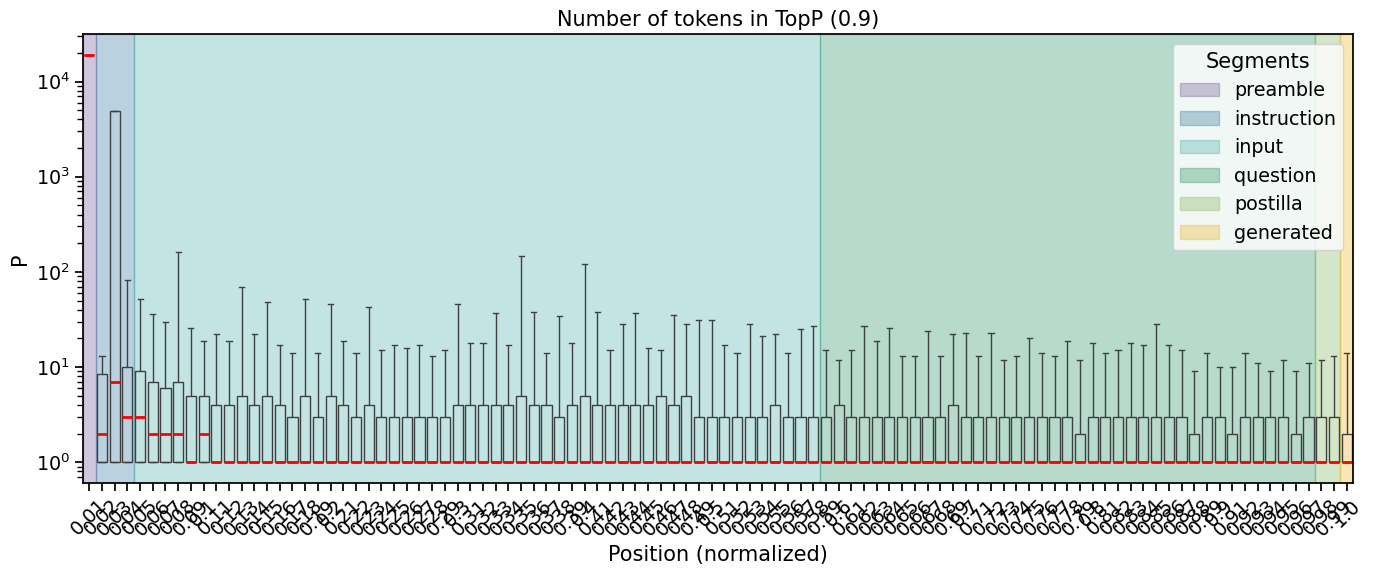

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

# Sort for proper order
df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)  # Assign numerical index

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="shape", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("Number of tokens in TopP (0.9)")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

## multiple runs

### check no variance in forward

In [80]:
mm[mm.area=='prompt'].true_ent.describe()

count    1.137204e+07
mean     7.961511e-01
std      1.202175e+00
min      0.000000e+00
25%      1.045520e-03
50%      1.538483e-01
75%      1.183405e+00
max      9.495135e+00
Name: true_ent, dtype: float64

In [81]:
mm

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,9,0,prompt,19127,9.342692,0.011505,0,40,preamble,0,40,0.000000,0.000000,0,-41
6,0,9,1,prompt,4954,6.863560,0.110962,0,40,preamble,0,40,0.025000,0.025000,1,-40
12,0,9,2,prompt,9,1.748911,0.684082,0,40,preamble,0,40,0.050000,0.050000,2,-39
18,0,9,3,prompt,178,4.617726,0.093811,0,40,preamble,0,40,0.075000,0.075000,3,-38
24,0,9,4,prompt,5,1.100033,0.811523,0,40,preamble,0,40,0.100000,0.100000,4,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68765189,4,1797,5483,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999271,5.826087,19,-5
68765195,4,1797,5484,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999453,5.869565,20,-4
68765201,4,1797,5485,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999636,5.913043,21,-3
68765207,4,1797,5486,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999818,5.956522,22,-2


In [82]:
# variance before generate
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['true_ent'].var().sum()

0.0

In [83]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['shape'].var().sum()

0.0

In [84]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['maxp'].var().sum()

0.0

In [85]:
# variance after generate
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['true_ent'].var().sum()

17.780674

In [86]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['shape'].var().sum()

102.3

In [87]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var().sum()

3.644291689544074

In [88]:
mm[mm.segment=='generated'].sort_values(['pid', 'tok'], ascending=[True,True]).to_excel("delme.xlsx")

### search prompts for which top-p varies

In [89]:
myvars = mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var()
variators = myvars[myvars>0.].to_frame().reset_index().pid.unique()

In [90]:
mv = mm[mm.pid.isin(variators)]

In [91]:
# prompts for which we observe an observable change over runs
v1 = mv.pid.unique()
v1

array([   9,   14,   17,   18,   45,  128,  130,  164,  238,  298,  300,
        311,  320,  368,  382,  391,  394,  446,  458,  482,  484,  516,
        521,  533,  584,  632,  633,  698,  718,  728,  741,  753,  766,
        782,  785,  805,  829,  839,  854,  879,  880,  884,  886,  902,
        916,  928,  952,  998, 1009, 1011, 1017, 1018, 1029, 1034, 1044,
       1069, 1070, 1071, 1099, 1116, 1123, 1140, 1142, 1149, 1160, 1191,
       1212, 1245, 1329, 1376, 1423, 1431, 1489, 1523, 1561, 1582, 1602,
       1632, 1643, 1644])

In [92]:
avg_truth = truth.groupby('pid').correct.mean().to_frame().reset_index()

In [93]:
# prompts for which we observe an output change over runs
v2 = avg_truth[avg_truth.correct<1.].pid.unique()
v2

array([   9,   10,   12,   14,   17,   18,   23,   41,   45,   63,   74,
         79,   85,   86,   89,   94,   99,  109,  112,  119,  123,  125,
        128,  130,  134,  137,  138,  139,  149,  164,  177,  181,  182,
        187,  188,  190,  194,  195,  200,  208,  209,  216,  218,  221,
        224,  229,  238,  265,  269,  270,  278,  279,  288,  292,  297,
        298,  300,  302,  307,  308,  310,  311,  312,  318,  320,  328,
        329,  330,  342,  344,  352,  359,  364,  367,  368,  374,  382,
        385,  388,  391,  394,  398,  403,  404,  408,  409,  421,  440,
        442,  446,  453,  454,  457,  458,  474,  476,  481,  482,  484,
        486,  492,  493,  496,  507,  511,  516,  518,  521,  533,  556,
        558,  561,  565,  583,  584,  590,  592,  607,  613,  614,  621,
        627,  628,  629,  632,  633,  639,  658,  662,  667,  682,  694,
        698,  699,  708,  711,  715,  717,  718,  719,  723,  725,  728,
        731,  741,  743,  753,  757,  758,  766,  7

In [94]:
set(v1) - set(v2)

set()

In [95]:
# correctness over prompts for which observable changed over different runs
avg_truth[avg_truth.pid.isin(v1)]

,pid,correct
0,9,0.2
3,14,0.2
4,17,0.8
5,18,0.8
14,45,0.2
...,...,...
601,1582,0.6
612,1602,0.4
627,1632,0.8
632,1643,0.8


In [96]:
# ??? correctness over prompts for which observable did NOT change over different runs
avg_truth[(~avg_truth.pid.isin(v1)) & (avg_truth.correct<1.) & (avg_truth.correct>0.)]

,pid,correct
13,41,0.6
20,63,0.6
25,74,0.4
32,89,0.8
35,94,0.2
...,...,...
669,1751,0.8
672,1760,0.2
679,1775,0.4
680,1776,0.8


In [97]:
m_

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end,tok_bin,tok_bin_hi,tok_bin_lo
38831,0,9,6471,generated,1,0.000000,1.000000,6471,6503,generated,5,32,0.995079,5.000000,0,-33,"(4.98, 5.04]",5.04,4.98
38837,0,9,6472,generated,1,0.000000,1.000000,6471,6503,generated,5,32,0.995233,5.031250,1,-32,"(4.98, 5.04]",5.04,4.98
38843,0,9,6473,generated,1,0.000000,1.000000,6471,6503,generated,5,32,0.995387,5.062500,2,-31,"(5.04, 5.1]",5.10,5.04
38849,0,9,6474,generated,2,0.692385,0.519521,6471,6503,generated,5,32,0.995541,5.093750,3,-30,"(5.04, 5.1]",5.10,5.04
38855,0,9,6475,generated,1,0.000000,1.000000,6471,6503,generated,5,32,0.995694,5.125000,4,-29,"(5.1, 5.16]",5.16,5.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13753049,0,1797,5483,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999271,5.826087,19,-5,"(5.82, 5.88]",5.88,5.82
13753055,0,1797,5484,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999453,5.869565,20,-4,"(5.82, 5.88]",5.88,5.82
13753061,0,1797,5485,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999636,5.913043,21,-3,"(5.88, 5.94]",5.94,5.88
13753067,0,1797,5486,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999818,5.956522,22,-2,"(5.94, 6.0]",6.00,5.94


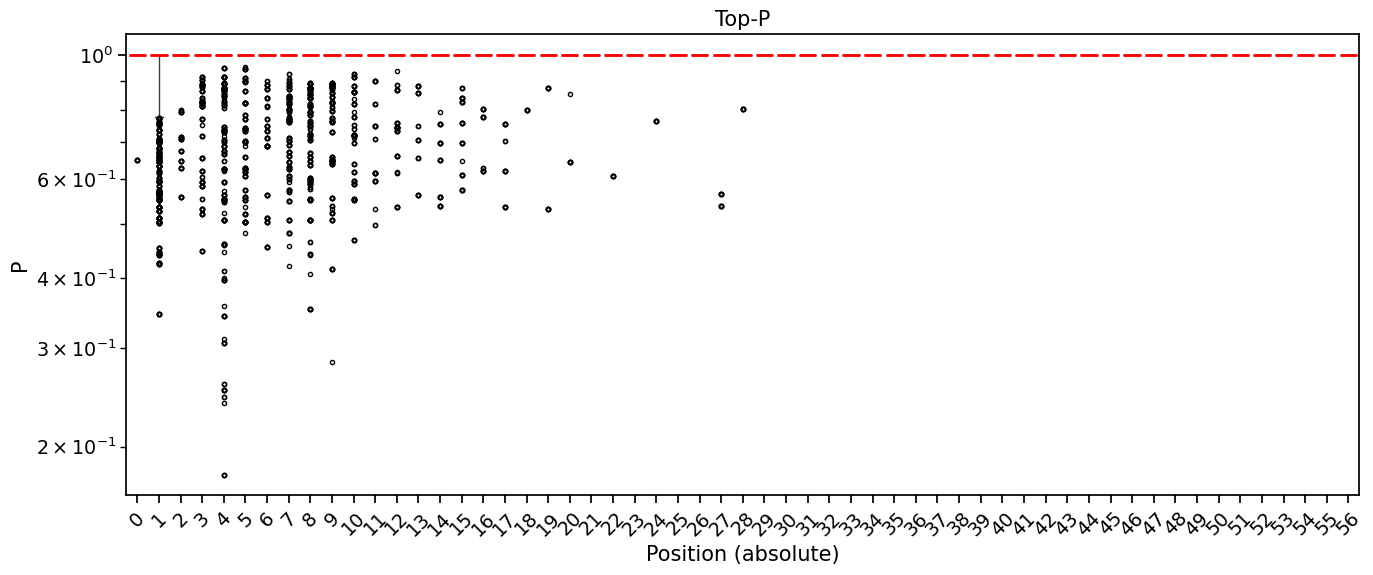

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
m_['tokzero'] = m_['tok'] - m_['start']
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

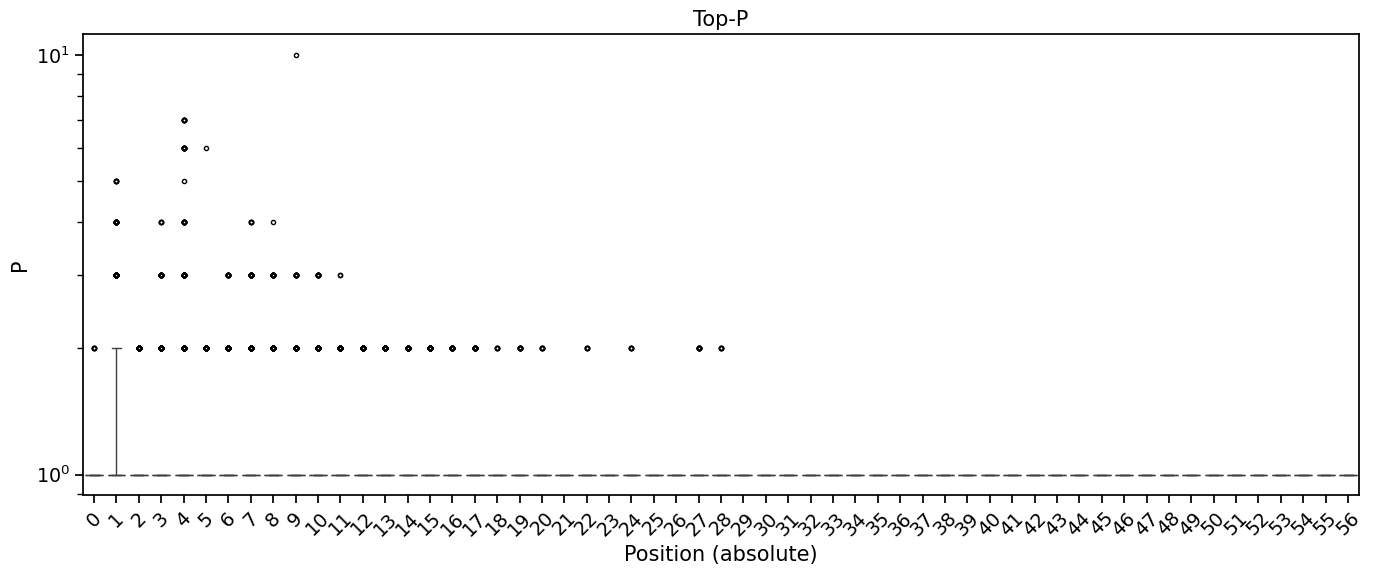

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()

m_['tokzero'] = m_['tok'] - m_['start']

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [100]:
m_

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
38831,0,9,6471,generated,1,0.000000,1.000000,6471,6503,generated,5,32,0.995079,5.000000,0,-33
38837,0,9,6472,generated,1,0.000000,1.000000,6471,6503,generated,5,32,0.995233,5.031250,1,-32
38843,0,9,6473,generated,1,0.000000,1.000000,6471,6503,generated,5,32,0.995387,5.062500,2,-31
38849,0,9,6474,generated,2,0.692385,0.519521,6471,6503,generated,5,32,0.995541,5.093750,3,-30
38855,0,9,6475,generated,1,0.000000,1.000000,6471,6503,generated,5,32,0.995694,5.125000,4,-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68765189,4,1797,5483,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999271,5.826087,19,-5
68765195,4,1797,5484,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999453,5.869565,20,-4
68765201,4,1797,5485,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999636,5.913043,21,-3
68765207,4,1797,5486,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999818,5.956522,22,-2


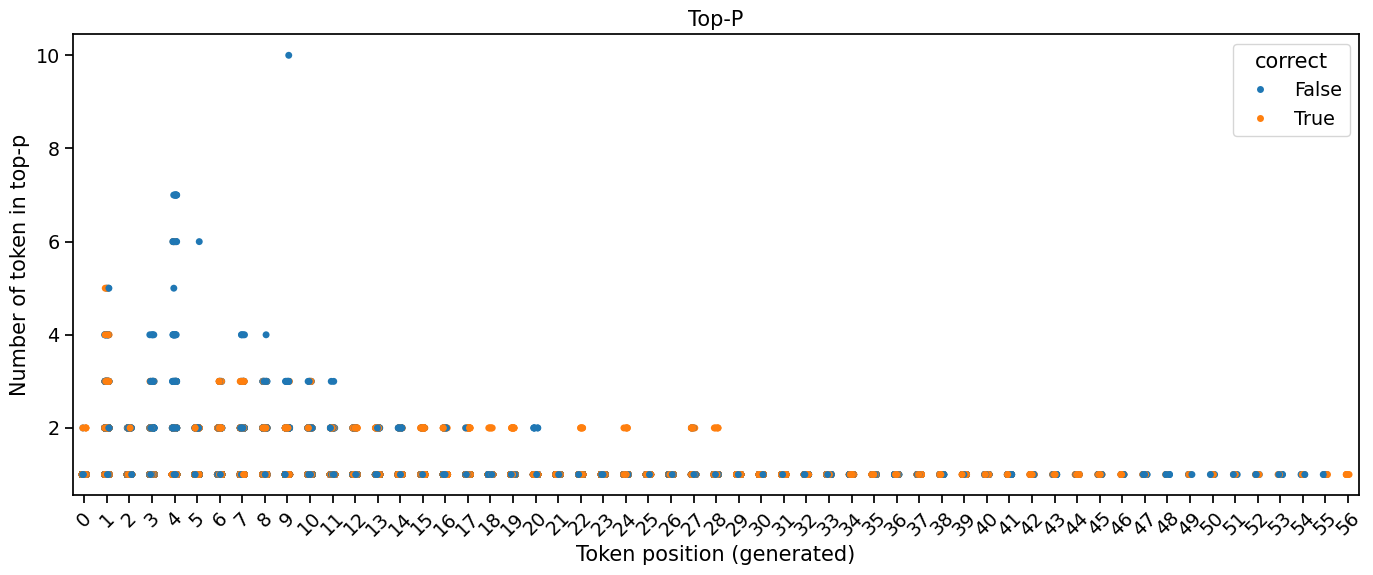

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.ylabel("Number of token in top-p")
plt.xlabel("Token position (generated)")
plt.title("Top-P")


plt.tight_layout()

plt.show()

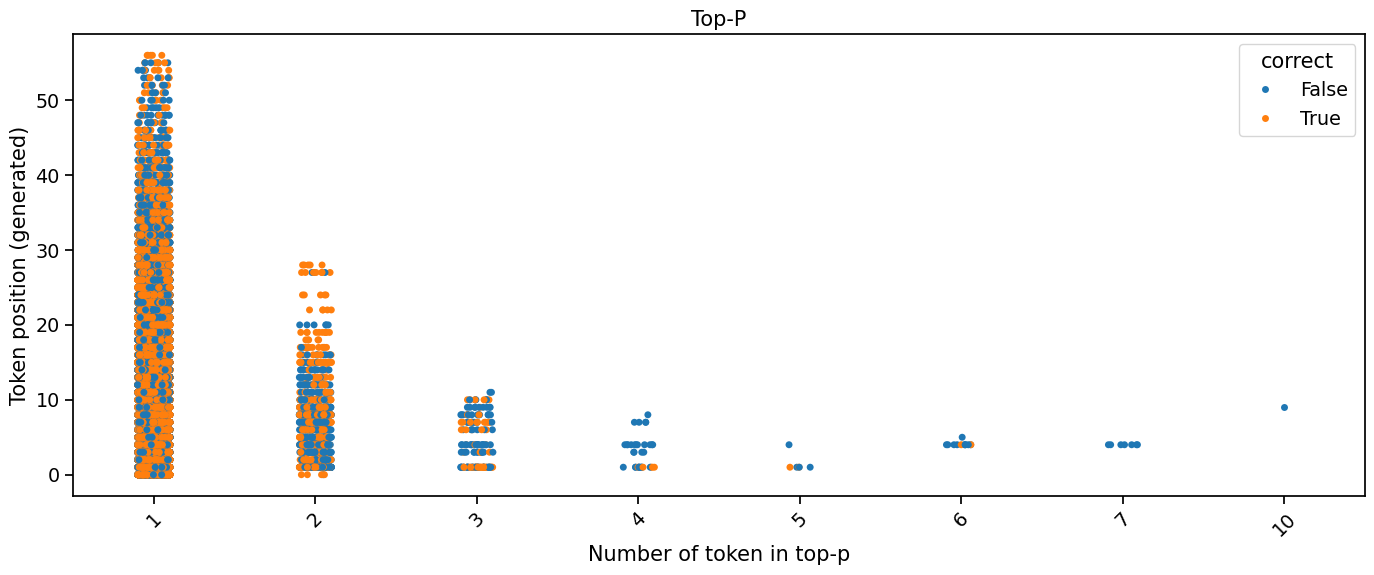

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    y="tokzero", 
    x="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Number of token in top-p")
plt.ylabel("Token position (generated)")
plt.title("Number of tokens")


plt.tight_layout()

plt.show()

In [102]:
m_.groupby('shape').correct.agg(['count', 'mean'])

,count,mean
shape,,
1,86995,0.686936
2,1605,0.492212
3,168,0.357143
4,35,0.142857
5,6,0.333333
6,12,0.166667
7,7,0.000000
10,1,0.000000


In [103]:
# 2%
m_.groupby('shape').correct.count() / m_.groupby('shape').correct.count().sum()

shape
1     0.979354
2     0.018068
3     0.001891
4     0.000394
5     0.000068
6     0.000135
7     0.000079
10    0.000011
Name: correct, dtype: float64

In [104]:
mm[mm.segment=='generated'].true_ent.describe()

count    88829.000000
mean         0.013205
std          0.096252
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.298839
Name: true_ent, dtype: float64

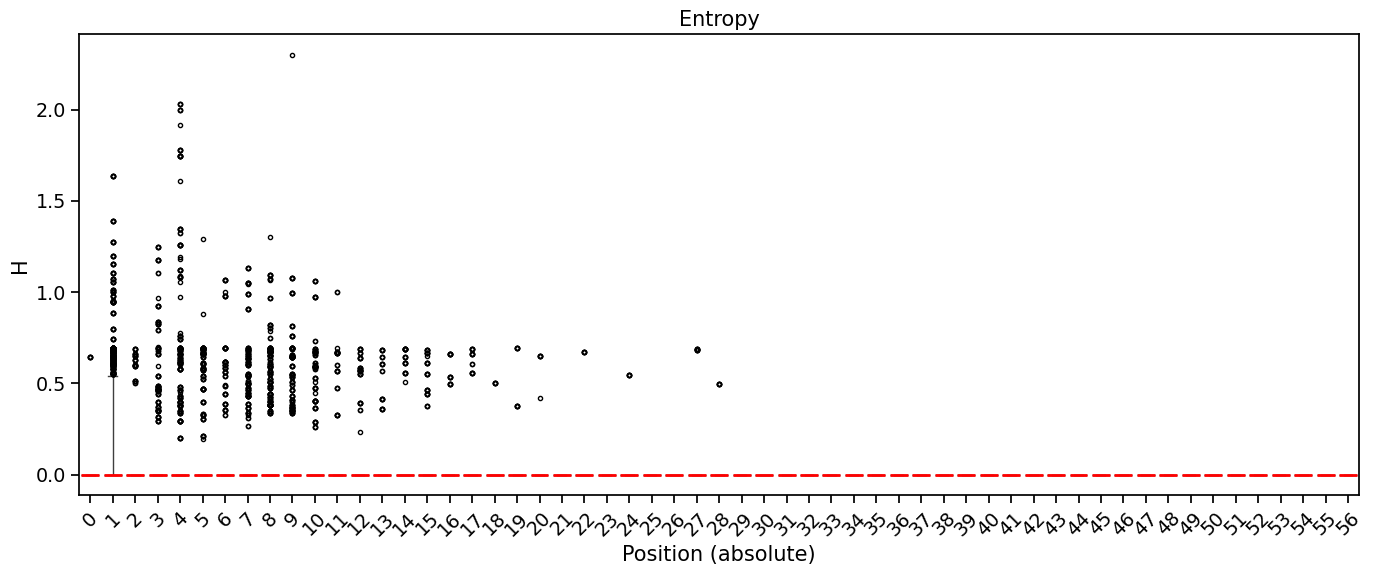

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

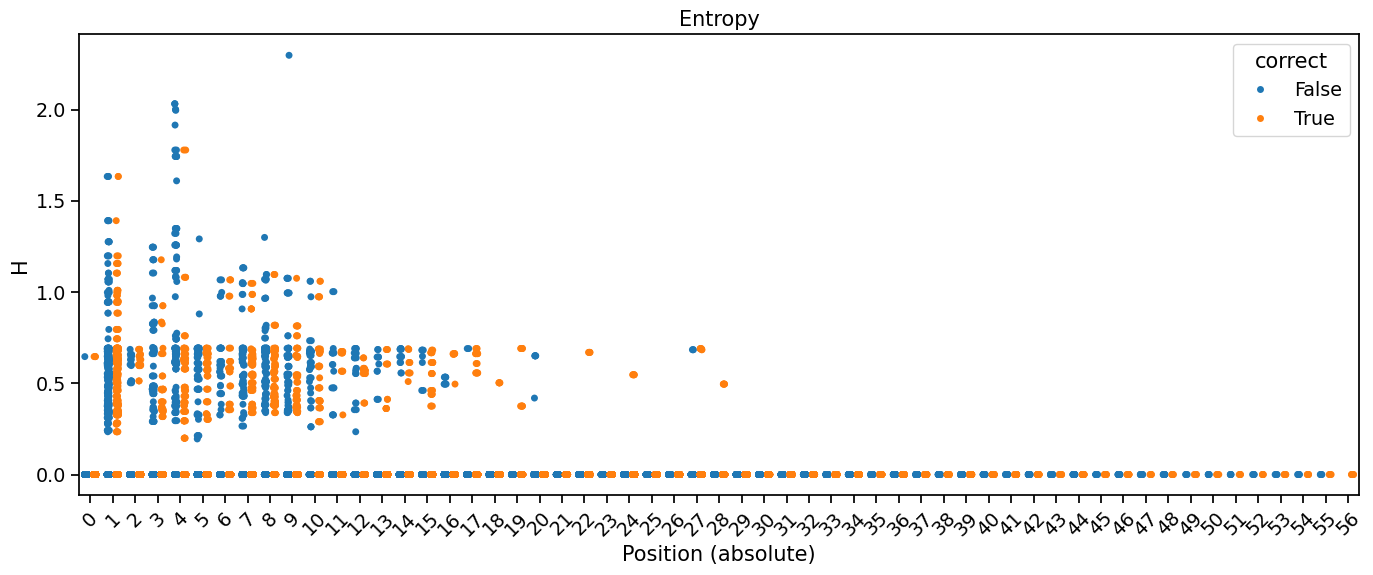

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m_ = mm[mm.segment=='generated'].copy()

m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    hue='correct',
    dodge=True,
    size=5,
    ax = ax
)


plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

In [107]:
mm[(mm.segment=='generated') & (mm.pid==1)]

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end


In [108]:
mm[(mm.segment=='generated') & (mm.pid==2)]

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end


In [109]:
mm.shape

(11460869, 16)

In [110]:
m.shape

(2292179, 19)

In [76]:
# TODO: compare variance in generate (same prompt / multiple prompts)

In [77]:
# TODO: compare observables grouping by truth

In [181]:
# TODO: plot truth vs aggregated uncertainty